In [1]:
!pip install unsloth transformers trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.3/432.3 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.5/376.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from unsloth import FastLanguageModel
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth.chat_templates import get_chat_template,standardize_sharegpt


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
model,tokenizer =FastLanguageModel.from_pretrained(
    model_name="unsloth/llama-3-8b-bnb-4bit",
    max_seq_length= 2048,
    load_in_4bit=True
    )

==((====))==  Unsloth 2026.2.1: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.35. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

In [4]:
model=FastLanguageModel.get_peft_model(
    model,r=32,
    target_modules=["q_proj","k_proj","v_proj","gate_proj","up_proj","down_proj"]
)

Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2026.2.1 patched 32 layers with 32 QKV layers, 0 O layers and 32 MLP layers.


In [5]:
tokenizer = get_chat_template(tokenizer,chat_template = "llama-3.1")

In [6]:
dataset=load_dataset("b-mc2/sql-create-context",split="train")

README.md: 0.00B [00:00, ?B/s]

sql_create_context_v4.json:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78577 [00:00<?, ? examples/s]

In [7]:
dataset= standardize_sharegpt(dataset)

In [8]:
dataset

Dataset({
    features: ['answer', 'question', 'context'],
    num_rows: 78577
})

In [9]:
dataset[0]

{'answer': 'SELECT COUNT(*) FROM head WHERE age > 56',
 'question': 'How many heads of the departments are older than 56 ?',
 'context': 'CREATE TABLE head (age INTEGER)'}

In [10]:
# dataset= dataset.map(
#     lambda examples:{
#         "text":[
#             tokenizer.apply_chat_template(temp,tokenize=False)
#             for temp in dataset
#         ]
#     },
#     batched=True
# )

In [11]:
PROMPT_TEMPLATE = """Below is an instruction that describes a task, paired with context that provides further details. Write a response that appropriately completes the request.

### Instruction:
Write a SQL query to answer the following question given the database schema.
Question: {question}

### Context:
{context}

### Response:
{answer}"""

In [12]:
def format_prompt(example):
    """Format a single dataset example into a training prompt."""
    return PROMPT_TEMPLATE.format(
        question=example['question'],
        context=example['context'],
        answer=example['answer'],
    )

# Test the formatter
sample = dataset[0]
formatted = format_prompt(sample)
print(" Example formatted prompt:")
print(formatted)
print(f"\n Token estimate: {len(formatted.split())} words")

 Example formatted prompt:
Below is an instruction that describes a task, paired with context that provides further details. Write a response that appropriately completes the request.

### Instruction:
Write a SQL query to answer the following question given the database schema.
Question: How many heads of the departments are older than 56 ?

### Context:
CREATE TABLE head (age INTEGER)

### Response:
SELECT COUNT(*) FROM head WHERE age > 56

 Token estimate: 67 words


In [13]:
# Apply formatting to the full dataset
def formatting_func(examples):
    """Batch formatting for SFTTrainer."""
    texts = []
    for q, c, a in zip(examples['question'], examples['context'], examples['answer']):
        text = PROMPT_TEMPLATE.format(question=q, context=c, answer=a)
        texts.append(text)
    return {"text": texts}

# Map formatting across the dataset
formatted_dataset = dataset.map(
    formatting_func,
    batched=True,
    remove_columns=dataset.column_names,
    desc="Formatting prompts",
)


Formatting prompts:   0%|          | 0/78577 [00:00<?, ? examples/s]

In [14]:
formatted_dataset[0]

{'text': 'Below is an instruction that describes a task, paired with context that provides further details. Write a response that appropriately completes the request.\n\n### Instruction:\nWrite a SQL query to answer the following question given the database schema.\nQuestion: How many heads of the departments are older than 56 ?\n\n### Context:\nCREATE TABLE head (age INTEGER)\n\n### Response:\nSELECT COUNT(*) FROM head WHERE age > 56'}

In [15]:
# Train / eval split
splits = formatted_dataset.train_test_split(test_size= 0.0006 , seed=42)
train_dataset = splits['train']
eval_dataset = splits['test']

print(f"Dataset formatted and split!")
print(f"Train samples : {len(train_dataset):,}")
print(f"Eval samples : {len(eval_dataset):,}")

Dataset formatted and split!
Train samples : 78,529
Eval samples : 48


In [45]:
trainer= SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    args = TrainingArguments(
        num_train_epochs = 1,
        per_device_train_batch_size = 1,
        gradient_accumulation_steps= 2,
        warmup_steps = 5,
        max_steps= 1000,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 25,
        save_steps = 200,
        eval_steps = 25,
        eval_strategy = "steps",
        save_strategy = "steps",
        load_best_model_at_end = True,
        metric_for_best_model = "eval_loss",
        optim = "adamw_8bit",  # 8-bit Adam saves memory
        seed = 42,
        report_to = "none",         # Change to "wandb" for tracking
        dataloader_num_workers = 2
        )
)

In [46]:
import time
start_time = time.time()
trainer_stats = trainer.train()
elapsed = time.time() - start_time
print(f"Time elapsed : {elapsed/60:.1f} minutes")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 78,529 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 2 x 1) = 2
 "-____-"     Trainable parameters = 75,497,472 of 8,105,758,720 (0.93% trained)


Step,Training Loss,Validation Loss
25,0.449400,0.688831
50,0.420600,0.754586
75,0.447200,0.692822
100,0.519800,0.662299
125,0.558900,0.655753
150,0.543100,0.640988
175,0.500400,0.644412
200,0.530900,0.649885
225,0.512200,0.637111
250,0.525700,0.616437


Time elapsed : 29.5 minutes


In [30]:
import sqlite3
import re
from tqdm import tqdm

# Switch model to inference mode (2x faster)
FastLanguageModel.for_inference(model)

def generate_sql(question: str, context: str, max_new_tokens: int = 256) -> str:
    """Generate SQL from a natural language question + schema context."""
    prompt = INFERENCE_TEMPLATE.format(question=question, context=context)
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=2048,
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens = max_new_tokens,
            do_sample  = False,      # Greedy for SQL (deterministic)
            temperature = 1.0,
            use_cache = True,
            pad_token_id = tokenizer.eos_token_id,
            eos_token_id = tokenizer.eos_token_id,
        )

    # Decode only the newly generated tokens
    new_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    sql = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()
    return sql


def validate_sql_syntax(sql: str, context: str) -> bool:
    """Check if generated SQL is executable against a temp SQLite DB."""
    try:
        conn = sqlite3.connect(":memory:")
        cur  = conn.cursor()
        # Execute all CREATE TABLE statements from context
        for stmt in context.strip().split(";"):
            stmt = stmt.strip()
            if stmt.upper().startswith("CREATE"):
                cur.execute(stmt)
        # Try running the generated SQL
        cur.execute(sql)
        conn.close()
        return True
    except Exception:
        return False


def normalize_sql(sql: str) -> str:
    """Normalize SQL for comparison — lowercase, strip whitespace."""
    sql = sql.lower().strip()
    sql = re.sub(r'\s+', ' ', sql)
    sql = sql.rstrip(';')
    return sql


print("Evaluation functions ready!")

Evaluation functions ready!


In [47]:
INFERENCE_TEMPLATE = """Below is an instruction that describes a task, paired with context that provides further details. Write a response that appropriately completes the request.

### Instruction:
Write a SQL query to answer the following question given the database schema.
Question: {question}

### Context:
{context}

### Response:
"""

In [48]:
# Run evaluation on a sample of the eval set
EVAL_SAMPLES = 200   # Increase for more thorough eval (slower)

eval_subset = eval_dataset.select(range(min(200, len(eval_dataset))))
# Re-load original columns for eval
raw_eval = dataset.train_test_split(test_size=0.05, seed=42)['test']
raw_eval_subset = raw_eval.select(range(min(200, len(raw_eval))))

results = []
exact_matches = 0
syntax_valid = 0
errors = []

print(f"Evaluating on {EVAL_SAMPLES} samples...")

for sample in tqdm(raw_eval_subset):
    predicted_sql = generate_sql(sample['question'], sample['context'])
    ground_truth = sample['answer']

    is_valid = validate_sql_syntax(predicted_sql, sample['context'])
    is_exact = normalize_sql(predicted_sql) == normalize_sql(ground_truth)

    if is_valid: syntax_valid += 1
    if is_exact: exact_matches += 1

    results.append({
        'question': sample['question'],
        'predicted': predicted_sql,
        'ground_truth': ground_truth,
        'syntax_valid': is_valid,
        'exact_match':  is_exact,
    })

n = len(results)
exact_pct = exact_matches/ n * 100
syntax_pct = syntax_valid/ n * 100

print("EVALUATION RESULTS")
print(f"Samples evaluated : {n}")
print(f"Exact Match : {exact_matches}/{n} ({exact_pct:.1f}%)")
print(f"Syntax Valid : {syntax_valid}/{n} ({syntax_pct:.1f}%)")
print(f"Syntax Error Rate: {100-syntax_pct:.1f}%")


Evaluating on 200 samples...


100%|██████████| 200/200 [06:15<00:00,  1.88s/it]

EVALUATION RESULTS
Samples evaluated : 200
Exact Match : 148/200 (74.0%)
Syntax Valid : 193/200 (96.5%)
Syntax Error Rate: 3.5%


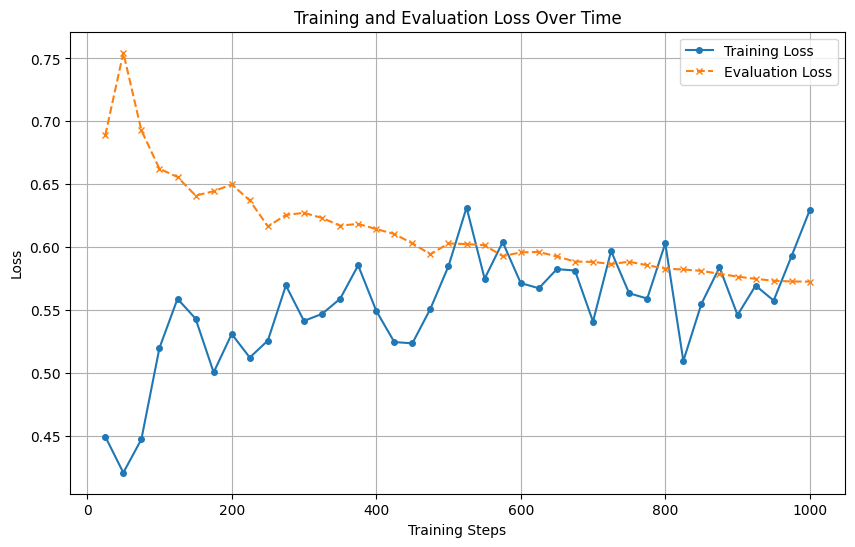

In [50]:
import json
import matplotlib.pyplot as plt

# Path to the trainer_state.json from the last checkpoint
TRAINER_STATE_PATH = '/content/trainer_output/checkpoint-1000/trainer_state.json'

with open(TRAINER_STATE_PATH, 'r') as f:
    trainer_state = json.load(f)

log_history = trainer_state['log_history']

# Create a dictionary for easier lookup and alignment of losses by step
loss_data = {}
for log in log_history:
    step = log.get('step')
    if step is not None:
        if step not in loss_data: loss_data[step] = {}
        if 'loss' in log: loss_data[step]['train_loss'] = log['loss']
        if 'eval_loss' in log: loss_data[step]['eval_loss'] = log['eval_loss']

# Extract and align data for plotting
aligned_steps = []
aligned_training_losses = []
aligned_eval_losses = []

sorted_steps = sorted(loss_data.keys())
for step in sorted_steps:
    aligned_steps.append(step)
    aligned_training_losses.append(loss_data[step].get('train_loss'))
    aligned_eval_losses.append(loss_data[step].get('eval_loss'))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(aligned_steps, aligned_training_losses, label='Training Loss', marker='o', markersize=4, linestyle='-')
plt.plot(aligned_steps, aligned_eval_losses, label='Evaluation Loss', marker='x', markersize=4, linestyle='--')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# LORA_SAVE_DIR = "./junior-sql-lora"

# model.save_pretrained(LORA_SAVE_DIR)
# tokenizer.save_pretrained(LORA_SAVE_DIR)

# print(f"LoRA adapters saved to: {LORA_SAVE_DIR}")


In [ ]:
# MERGED_SAVE_DIR = "./junior-sql-merged"

# print("Merging LoRA weights into base model (takes ~2-3 min)...")
# model.save_pretrained_merged(
#     MERGED_SAVE_DIR,
#     tokenizer,
#     save_method="merged_16bit",   # Options: merged_16bit, merged_4bit, lora
# )

# print(f"Merged model saved to: {MERGED_SAVE_DIR}")